<a href="https://colab.research.google.com/github/adalves-ufabc/2022.Q2-PLN/blob/main/2022_Q2_PLN_Notebook_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural [2022.Q2]**
Prof. Alexandre Donizeti Alves

### **Sistema de Perguntas e Respostas** 
----

Neste caderno aprenderemos dois dos métodos básicos para implementar um **Sistema de Perguntas e Respostas** (*Question Answering (QA) System*).

O **Sistema de Perguntas e Respostas** (QA) é um sistema de recuperação de informações em que uma resposta direta é esperada em resposta a uma consulta enviada, em vez de um conjunto de referências que pode conter as respostas. Os QAs visam satisfazer os usuários que buscam responder a uma pergunta específica em linguagem natural. 
>
O **sistema de QA** funciona como um mecanismo de pesquisa, mas com representação de resultado diferente: o mecanismo de pesquisa retorna uma lista de links para recursos de resposta, enquanto o sistema de QA dá uma resposta direta à pergunta.

>
O processo de recuperação de informações no sistema de QA é dividido em 3 estágios: processamento das perguntas, classificação (*ranking*)) e extração de respostas. O processamento das perguntas e a classificação podem ser realizados usando funções algorítmicas ou Aprendizado de Máquina.

>
O sistema de QA com função de correspondência aproximada (*approximate match function*) é simples como:

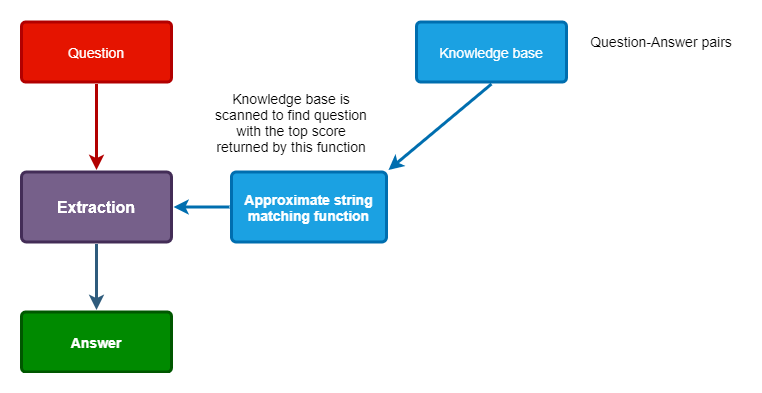

**Dados**

Para fins de demonstração, usaremos um conjunto extremamente pequeno de pares de perguntas e respostas armazenadas em um arquivo CSV. Para construir um sistema de QA de alta qualidade, você deve usar muitos exemplos de perguntas, armazenamento de dados especializados ou banco de dados para permitir consultas mais rápidas.

>
Em nossos exemplos, usaremos a base de conhecimento no estado em que se encontra, sem nenhuma modificação, mas você está livre para inserir exemplos de perguntas adicionais para melhorar a qualidade das respostas.
Vamos carregar os dados:

In [ ]:
import pandas as pd

data = pd.read_csv('/content/qa.csv')

# this function is used to get printable results
def getResults(questions, fn):
    def getResult(q):
        answer, score, prediction = fn(q)
        return [q, prediction, answer, score]

    return pd.DataFrame(list(map(getResult, questions)), columns=["Q", "Prediction", "A", "Score"])

test_data = [
    "What is the population of Egypt?",
    "What is the poulation of egypt",
    "How long is a leopard's tail?",
    "Do you know the length of leopard's tail?",
    "When polar bears can be invisible?",
    "Can I see arctic animals?",
    "some city in Finland"
]

data

,Question,Answer
0,Who determined the dependence of the boiling o...,Anders Celsius
1,Are beetles insects?,Yes
2,Are Canada 's two official languages English a...,yes
3,What is the population of Egypt?,more than 78 million
4,What is the biggest city in Finland?,Greater Helsinki
5,What is the national currency of Liechtenstein?,Swiss franc
6,Can polar bears be seen under infrared photogr...,Polar bears are nearly invisible under infrare...
7,When did Tesla demonstrate wireless communicat...,1893
8,What are violins made of?,different types of wood
9,How long is a leopard's tail?,60 to 110cm


## **Um sistema de QA simples**

Em sua forma mais simples, os sistemas de QA só podem responder se as perguntas e respostas corresponderem perfeitamente.

In [ ]:
import re

def getNaiveAnswer(q):
    # regex helps to pass some punctuation signs
    row = data.loc[data['Question'].str.contains(re.sub(r"[^\w'\s)]+", "", q),case=False)]
    if len(row) > 0:
        return row["Answer"].values[0], 1, row["Question"].values[0]
    return "Sorry, I didn't get you.", 0, ""

getResults(test_data, getNaiveAnswer)

,Q,Prediction,A,Score
0,What is the population of Egypt?,What is the population of Egypt?,more than 78 million,1
1,What is the poulation of egypt,,"Sorry, I didn't get you.",0
2,How long is a leopard's tail?,How long is a leopard's tail?,60 to 110cm,1
3,Do you know the length of leopard's tail?,,"Sorry, I didn't get you.",0
4,When polar bears can be invisible?,,"Sorry, I didn't get you.",0
5,Can I see arctic animals?,,"Sorry, I didn't get you.",0
6,some city in Finland,,"Sorry, I didn't get you.",0


Como você pode ver, um pequeno erro gramatical pode  atrapalhar todo o processo. É o mesmo resultado se você usar o pré-processamento nos dados de origem e nas consultas, como remoção de símbolos de pontuação, letras minúsculas etc.

>
Então, como podemos melhorar nossos resultados?

>
Para melhorar os resultados, vamos usar a **correspondência de string aproximada**. Assim, nosso sistema estará habilitado a aceitar erros gramaticais e pequenas diferenças no texto.

>
Há muitas maneiras de implantar protocolos de correspondência de string aproximada, mas para nosso exemplo, usaremos uma das implementações de métricas de string chamada **distância de Levenshtein**. Nesse cenário, a distância entre duas palavras é o número mínimo de edições de um único caractere (inserções, exclusões ou substituições) necessárias para transformar uma palavra na outra.


### **Sistema de QA aproximado**

Vamos usar a correspondência de strings aproximada para fazer nosso sistema admitir erros gramaticais e algumas diferenças no texto. Na Ciência da Computação, existem muitos métodos para fazer a correspondência de strings aproximada. Para os nossos propósitos de demonstração, usaremos uma das implementações de busca de string difusa, chamada **distância de Levenshtein**. Conforme já mencionado, a **distância Levenshtein** entre duas palavras é o número mínimo de edições de um único caractere (inserções, exclusões ou substituições) necessárias para transformar uma palavra na outra.


In [ ]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149879 sha256=f79b79132482ee71ae0839f0186b812a7492380741e394d60f778b3c5eb022fc
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
from Levenshtein import ratio

def getApproximateAnswer(q):
    max_score = 0
    answer = ""
    prediction = ""
    for idx, row in data.iterrows():
        score = ratio(row["Question"], q)
        if score >= 0.9: # I'm sure, stop here
            return row["Answer"], score, row["Question"]
        elif score > max_score: # I'm unsure, continue
            max_score = score
            answer = row["Answer"]
            prediction = row["Question"]

    if max_score > 0.8:
        return answer, max_score, prediction
    return "Sorry, I didn't get you.", max_score, prediction

getResults(test_data, getApproximateAnswer)

,Q,Prediction,A,Score
0,What is the population of Egypt?,What is the population of Egypt?,more than 78 million,1.000000
1,What is the poulation of egypt,What is the population of Egypt?,more than 78 million,0.935484
2,How long is a leopard's tail?,How long is a leopard's tail?,60 to 110cm,1.000000
3,Do you know the length of leopard's tail?,How long is a leopard's tail?,"Sorry, I didn't get you.",0.657143
4,When polar bears can be invisible?,Can polar bears be seen under infrared photogr...,"Sorry, I didn't get you.",0.517647
5,Can I see arctic animals?,What is the biggest city in Finland?,"Sorry, I didn't get you.",0.426230
6,some city in Finland,What is the biggest city in Finland?,"Sorry, I didn't get you.",0.642857


Como você pode ver, a segunda questão com dois erros gramaticais agora foi respondida, obtendo pontuação abaixo de 1.0, mas aceitavelmente alta. Por enquanto nosso sistema está melhor, ele pode fazer verificação ortográfica, mas ainda há problemas com perguntas escritas no idioma nativo. Vamos tentar ajustar o coeficiente `max_score` de nossa função para ser mais tolerante.

In [ ]:
from Levenshtein import ratio

def getApproximateAnswer2(q):
    max_score = 0
    answer = ""
    prediction = ""
    for idx, row in data.iterrows():
        score = ratio(row["Question"], q)
        if score >= 0.9: # I'm sure, stop here
            return row["Answer"], score, row["Question"]
        elif score > max_score: # I'm unsure, continue
            max_score = score
            answer = row["Answer"]
            prediction = row["Question"]

    if max_score > 0.3: # treshold is lowered
        return answer, max_score, prediction
    return "Sorry, I didn't get you.", max_score, prediction

getResults(test_data, getApproximateAnswer2)

,Q,Prediction,A,Score
0,What is the population of Egypt?,What is the population of Egypt?,more than 78 million,1.000000
1,What is the poulation of egypt,What is the population of Egypt?,more than 78 million,0.935484
2,How long is a leopard's tail?,How long is a leopard's tail?,60 to 110cm,1.000000
3,Do you know the length of leopard's tail?,How long is a leopard's tail?,60 to 110cm,0.657143
4,When polar bears can be invisible?,Can polar bears be seen under infrared photogr...,Polar bears are nearly invisible under infrare...,0.517647
5,Can I see arctic animals?,What is the biggest city in Finland?,Greater Helsinki,0.426230
6,some city in Finland,What is the biggest city in Finland?,Greater Helsinki,0.642857


Os resultados evidenciam que mesmo quando palavras diferentes são usadas, o sistema pode responder com a resposta correta. Mas se você olhar mais de perto, o  resultado de índice 5 é um falso positivo.

>
O exemplo apresentado é uma demonstração simples de como isso funciona. O código é bastante simples e impraticável de usar com grandes volumes e iterações em um grande conjunto de dados.

>
Isso significa que temos que levar isso para o próximo nível e aproveitar as bibliotecas avançadas que foram disponibilizadas por empresas como o Facebook e o Google para superar esses desafios.

>
A conhecida biblioteca BERT, desenvolvida pelo Google, é mais adequada para tarefas corporativas. Os sistemas de QA com tecnologia de IA com os quais você já se envolveu usam bancos de dados muito mais avançados e se envolvem em aprendizado de máquina contínuo.

**Mais informações**:

> https://www.kdnuggets.com/2020/04/simple-question-answering-systems-text-similarity-python.html